<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting/blob/main/myStocks_Chart_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance
import mplfinance as mpf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()

def get_chart(symbol, tf):
  if tf == 'D':
    intvl, sma, lma, xlma, prd, start_date, tfc = '1d', 20, 50, 200, '2y', '2023-01-01','Daily'
  else:
    intvl, sma, lma, xlma, prd, start_date, tfc = '1wk', 5, 10, 30, '6y', '2019-01-01','Weekly'

  # Sample data
  df = yfin.Ticker(symbol+'.NS').history(period=prd, interval=intvl)[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
  #df.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
  #df = pd.DataFrame(data)
  #df.set_index('Date', inplace=True)

  # Calculate moving averages
  df['MA_short'] = df['Close'].rolling(window=sma).mean()
  df['MA_long'] = df['Close'].rolling(window=lma).mean()
  df['MA_xlong'] = df['Close'].rolling(window=xlma).mean()

  df = df[df.index >= start_date]

  # Create a figure and plot the original data
  ax = df['Close'].plot(figsize=(16, 8), label='Close', color='skyblue')

  #ax = mpf.plot(df, type='candle', style='yahoo', figsize=(16, 8), title='Candlestick Chart with Moving Average')

  # Plot the moving averages
  #df['MA_short'].plot(ax=ax, label='MA Short', color='white')
  #df['MA_long'].plot(ax=ax, label='MA Long', color='white')
  df['MA_xlong'].plot(ax=ax, label='MA xLong', color='dimgrey', linestyle='dashed')

  # Fill the area between the moving averages
  ax.fill_between(df.index, df['MA_short'], df['MA_long'], where=(df['MA_short'] > df['MA_long']),
                  interpolate=True, color='paleturquoise', alpha=0.3, label='Bullish Crossover')
  ax.fill_between(df.index, df['MA_short'], df['MA_long'], where=(df['MA_short'] < df['MA_long']),
                  interpolate=True, color='lightcoral', alpha=0.3, label='Bearish Crossover')

  # Customize the plot
  ax.legend()
  ax.set_xlabel('Date')
  ax.set_ylabel('Close')
  plt.title(symbol+ ' - ' + tfc)
  plt.grid(True)
  plt.show()

In [3]:
import pandas as pd
import mplfinance as mpf

def get_chart(symbol, tf):
  if tf == 'D':
    intvl, sma, lma, xlma, prd, start_date, tfc = '1d', 20, 50, 200, '2y', '2023-01-01','Daily'
  elif tf == 'W':
    intvl, sma, lma, xlma, prd, start_date, tfc = '1wk', 5, 10, 30, '6y', '2019-01-01','Weekly'
  else:
    intvl, sma, lma, xlma, prd, start_date, tfc = '1mo', 2, 5, 10, '10y', '2013-01-01','Monthly'

  # Sample data with OHLCV (Open, High, Low, Close, Volume) prices
  # Sample data
  df = yfin.Ticker(symbol+'.NS').history(period=prd, interval=intvl)[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
  #df.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
  #df = pd.DataFrame(data)
  #df.set_index('Date', inplace=True)

  # Calculate moving averages
  df['MA_short'] = df['Close'].rolling(window=sma).mean()
  df['MA_long'] = df['Close'].rolling(window=lma).mean()
  df['MA_xlong'] = df['Close'].rolling(window=xlma).mean()

  df = df[df.index >= start_date]

  where_values1 = df['MA_short'].values>df['MA_long'].values
  where_values2 = df['MA_short'].values<df['MA_long'].values

  apds = [ mpf.make_addplot(df['MA_xlong'], color='dimgrey', linestyle='dashed'),
          mpf.make_addplot(df[['MA_short', 'MA_long']], fill_between=dict(y1=df['MA_short'].values,y2=df['MA_long'].values, where=where_values1, color='paleturquoise', alpha = .3), alpha = 0),
          mpf.make_addplot(df[['MA_short', 'MA_long']], fill_between=dict(y1=df['MA_short'].values,y2=df['MA_long'].values, where=where_values2, color='lightcoral', alpha = .3), alpha = 0)
        ]

  cols = ['Open', 'Close', 'Low', 'High', 'Volume']
  # Plot the candlestick chart with volume
  mpf.plot(df[cols], type='candle', style='yahoo', volume=True, addplot=apds, figsize=(16, 8), title=symbol+ ' - ' + tfc )

  # If you want to save the plot to a file, use the following line
  # mpf.plot(df, type='candle', style='yahoo', volume=True, title='Candlestick Chart with Volume', savefig='chart.png')

  mpf.show()

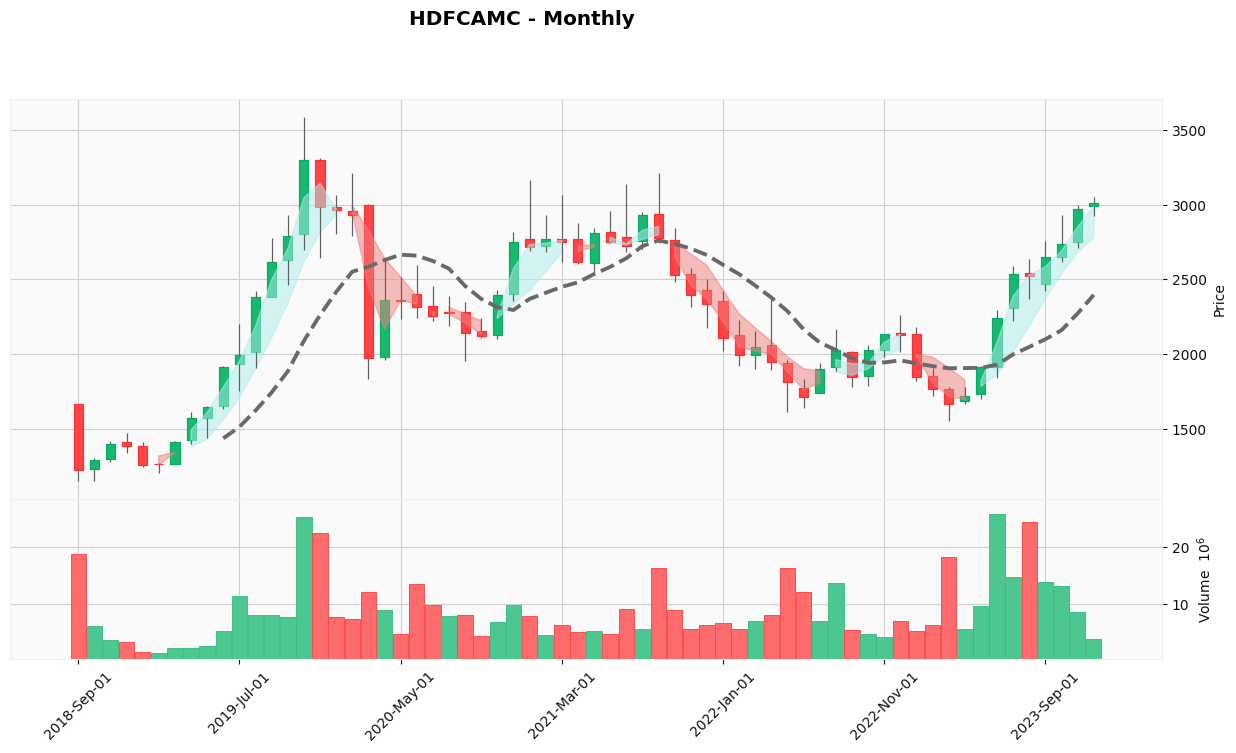

In [23]:
symbol = 'HDFCAMC'
get_chart(symbol, 'M')

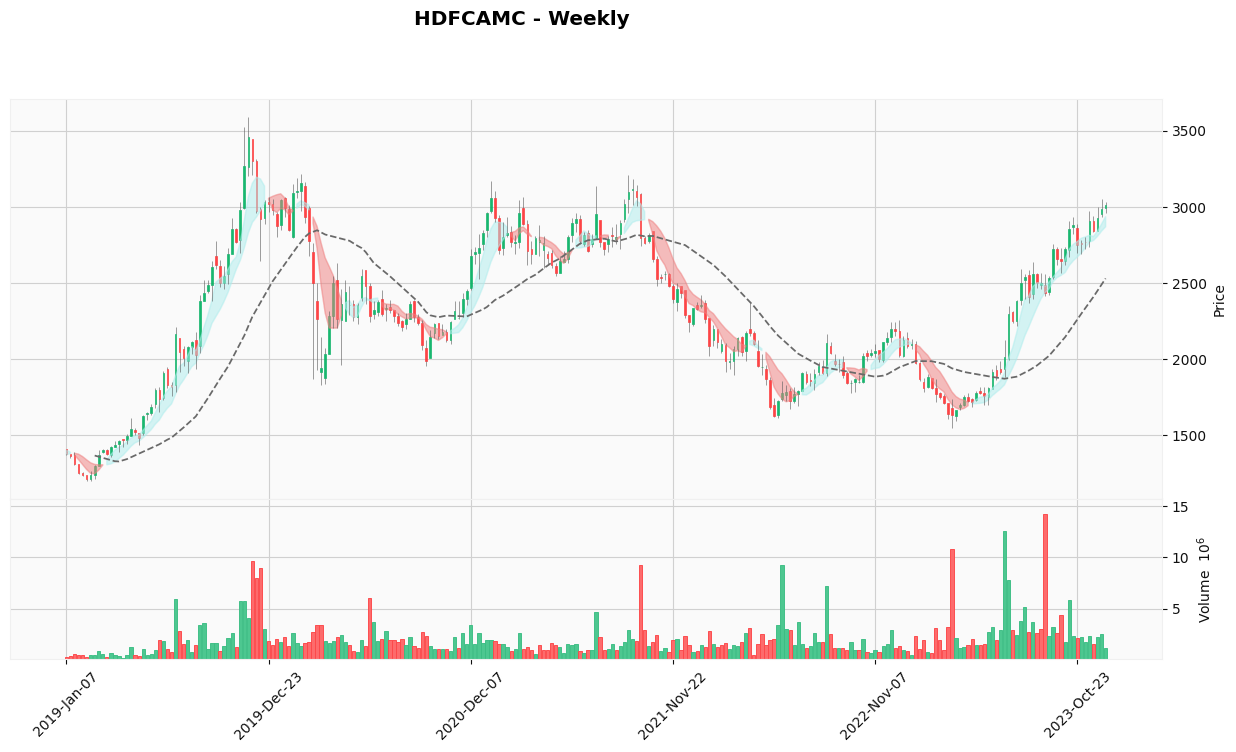

In [24]:
get_chart(symbol, 'W')

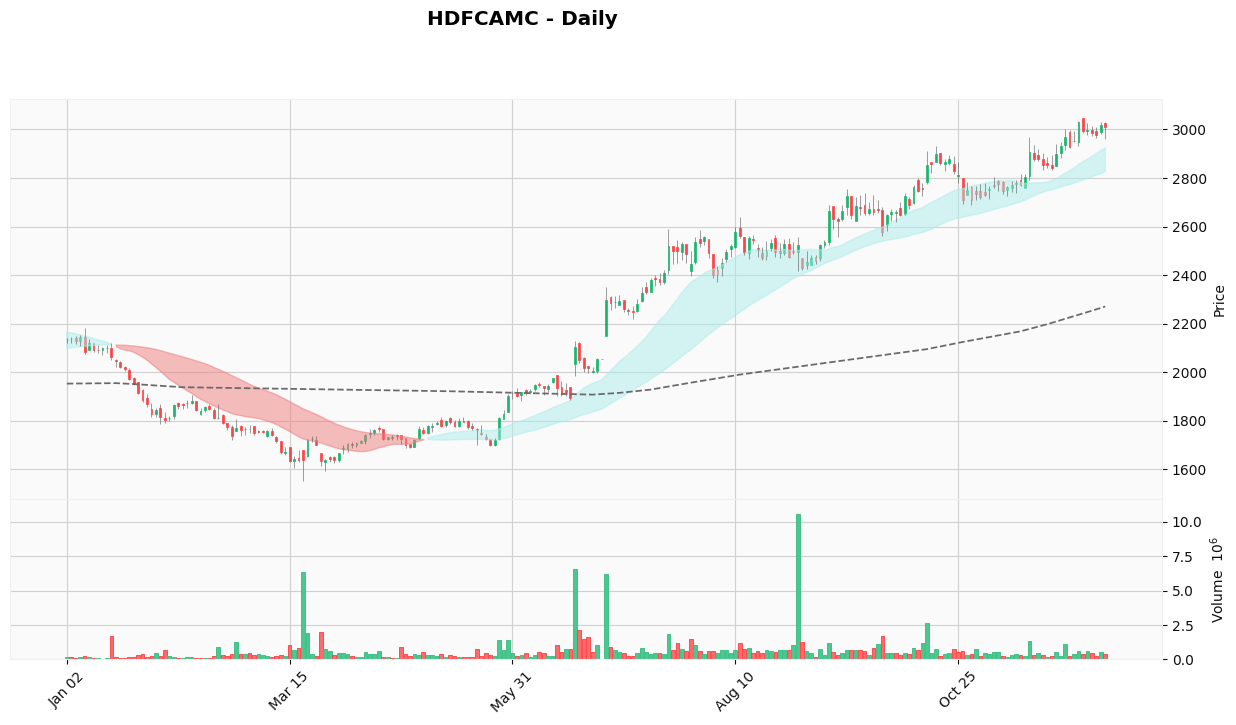

In [25]:
get_chart(symbol, 'D')